# 洗錢
- 筆記: https://www.notion.so/jayschsu/c6a6219dd004469bbbfbecfb6d9883f3

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import pandas as pd
import numpy as np 

from log import init_logging
from data import Data
from model import Model

pd.set_option('display.max_rows', 500)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)


### Data
- Raw Data
    - custinfo_df, ccba_df, cdtx_df, dp_df, remit_df, 
    - tr_alertX_df, tr_sarY_df, public_alertX_df
    - custinfo_valid
- Featuring (Date)
    - cdtxDate_df, dpDate_df, remitDate_df
- Featuring (Accumulate)
    - cdtx_feature, dp_feature, remit_feature
- Featuring (Intergrated)
    - data_df
    - Feature_Dict
- Sar Flag
    - moneyLundry dataset (sar_flag==1, in alert_date)
    - falseAlarm dataset (sar_flag==0, in alert_date)
    - public dataset (sar_flag==2, in alert_date)

In [5]:
dataset = Data()
model = Model(dataset)

2022-12-03 14:32:38,524 INFO: func:init_data: 3.19 sec (utils.py:16)
2022-12-03 14:32:38,525 INFO: custinfo_preprocess (data.py:54)
invalid_data_qty: 2
2022-12-03 14:32:38,666 INFO: func:custinfo_preprocess: 0.14 sec (utils.py:16)
2022-12-03 14:32:38,666 INFO: featuring_alertDate (data.py:83)
2022-12-03 14:33:07,653 INFO: func:featuring_alertDate: 28.99 sec (utils.py:16)
2022-12-03 14:33:07,655 INFO: featuring_accumulate (data.py:149)
2022-12-03 14:33:53,791 INFO: func:featuring_accumulate: 46.14 sec (utils.py:16)
2022-12-03 14:33:53,793 INFO: featuring_integrate (data.py:164)
2022-12-03 14:34:18,773 INFO: func:featuring_integrate: 24.98 sec (utils.py:16)


,sar_flag
0.0,23451
2.0,1770
1.0,233


dataset_Tr: (23684, 147)
dataset_TsPub: (1770, 147)
2022-12-03 14:34:18,825 INFO: func:init_data: 0.05 sec (utils.py:16)
hyperparameter combinations: 768


## MODEL

In [6]:
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 3)

In [7]:
dataset.data_df['sar_flag'].value_counts()

0.0    23451
2.0     1770
1.0      233
Name: sar_flag, dtype: int64

### 分群, 觀察數據
- TODO
    - outlier preprocess
- Algorithm
    - 計算待預測點最接近的K個點, 以距離加權評分
        - 待預測點: sar_flag=2
        - 加權: sar_score*距離
            - score = 1 if sar_flag=1
            - score = -1 if sar_flag=-1


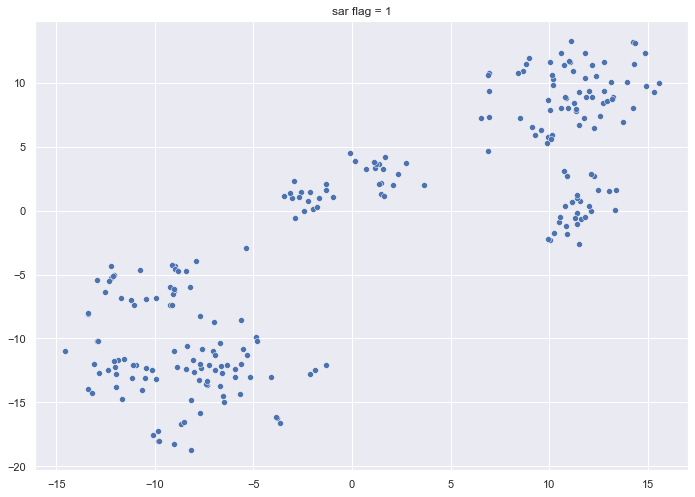

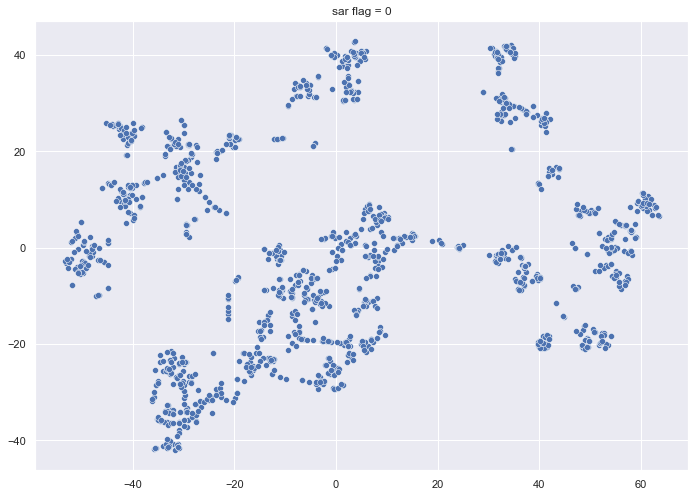

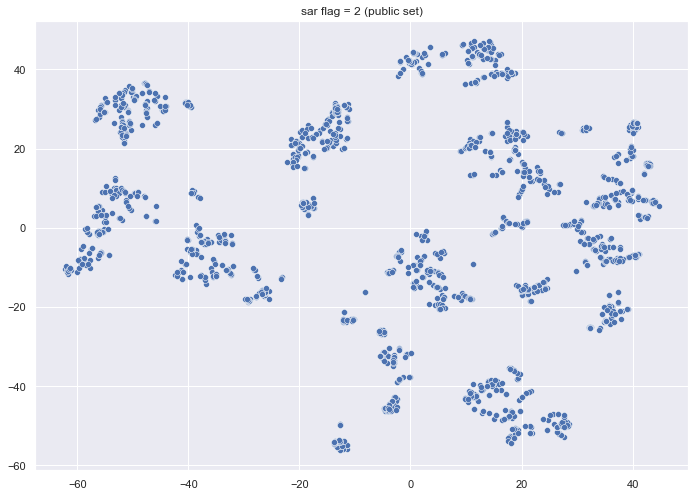

In [252]:
pipePre = Pipeline([('sc', MinMaxScaler()), ('pca', PCA(n_components=0.9))]) 
pipeTsne = Pipeline([('tsne', TSNE())]) 
pipeSpTom = imbPipeline([('sp', RandomUnderSampler(sampling_strategy={0:500, 2:500}))])


sar_df = dataset.data_df[dataset.data_df['sar_flag']==1]
X_tr = sar_df[dataset.Feature_Dict['feature_all']]
X_tr_pre = pipePre.fit_transform(X_tr.fillna(0))
X_embedded = pipeTsne.fit_transform(X_tr_pre)
palette = sns.color_palette("bright", 1)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], legend='full', palette=palette)
plt.title('sar flag = 1')
plt.show()

sar_df = dataset.data_df[dataset.data_df['sar_flag']==0]
sar_df = sar_df.sample(1500)
X_tr = sar_df[dataset.Feature_Dict['feature_all']]
X_tr_pre = pipePre.fit_transform(X_tr.fillna(0))
X_embedded = pipeTsne.fit_transform(X_tr_pre)
palette = sns.color_palette("bright", 1)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], legend='full', palette=palette)
plt.title('sar flag = 0')
plt.show()

sar_df = dataset.data_df[dataset.data_df['sar_flag']==2]
X_tr = sar_df[dataset.Feature_Dict['feature_all']]
X_tr_pre = pipePre.fit_transform(X_tr.fillna(0))
X_embedded = pipeTsne.fit_transform(X_tr_pre)
palette = sns.color_palette("bright", 1)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], legend='full', palette=palette)
plt.title('sar flag = 2 (public set)')
plt.show()

<AxesSubplot:>

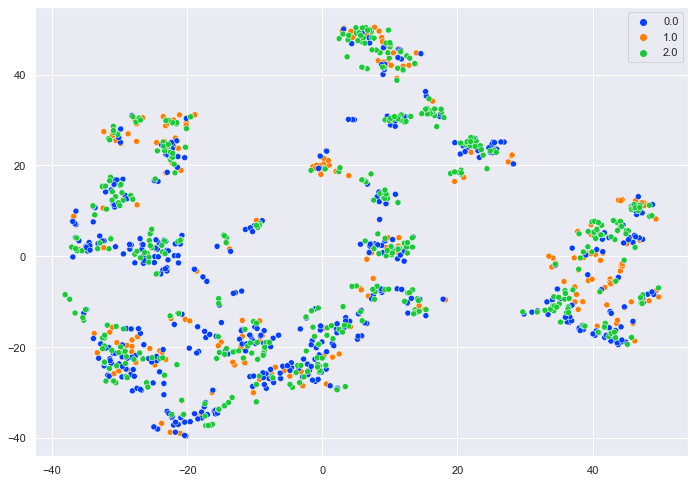

In [238]:
sar_df = dataset.data_df[dataset.data_df['sar_flag']==1]
pass_df = dataset.data_df[dataset.data_df['sar_flag']!=1]
X_tr = sar_df[dataset.Feature_Dict['feature_all']]
y_tr = sar_df['sar_flag']
X_val = pass_df[dataset.Feature_Dict['feature_all']]
y_val = pass_df['sar_flag']

X_tr_pre = pipePre.fit_transform(X_tr.fillna(0))
X_val_pre = pipePre.transform(X_val.fillna(0))
X_val_pre, y_val = pipeSpTom.fit_resample(X_val_pre, y_val)
X_tsne = np.concatenate([X_tr_pre,X_val_pre])
y_tsne = np.concatenate([y_tr, y_val])
#X_tsne = X_tr_pre
#y_tsne = y_tr

X_embedded = pipeTsne.fit_transform(X_tsne)
palette = sns.color_palette("bright", len(np.unique(y_tsne)))
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_tsne, legend='full', palette=palette)



In [10]:
pipePre = Pipeline([('sc', MinMaxScaler()), ('pca', PCA(n_components=0.9))]) 
pipeTsne = Pipeline([('tsne', TSNE())]) 
pipeSpTom = imbPipeline([('sp', RandomUnderSampler(sampling_strategy={0:500, 2:500}))])

x_tr = dataset.data_df[dataset.Feature_Dict['feature_all']]
y_tr = dataset.data_df['sar_flag']
x_tr_pre = pipePre.fit_transform(x_tr.fillna(0))
x_embedded = pipeTsne.fit_transform(x_tr_pre)
palette = sns.color_palette("bright", len(np.unique(y_tr)))
sns.scatterplot(x_embedded[:,0], x_embedded[:,1], hue=y_tr, legend='full', palette=palette)




NameError: name 'X_embedded' is not defined

<AxesSubplot:>

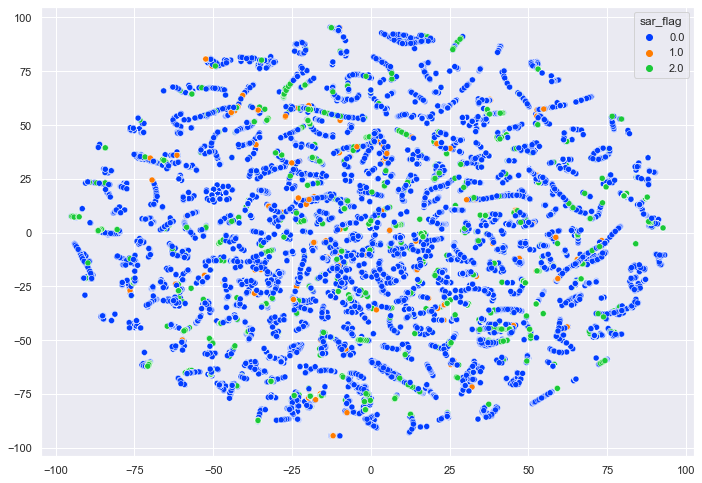

In [11]:
sns.scatterplot(x_embedded[:,0], x_embedded[:,1], hue=y_tr, legend='full', palette=palette)